In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import sys
sys.path.append('..')

### Analysis pipeline:
-  What are best/worst predictions visualization?
-  How the segmentation map is changing over levels? Which maps improve, which get worse or stay constant with stacking?
-  Does the 2nd level converge faster than the first level? 
-  Is the semantic part of the input used at all or mostly ignored, e.g. what happens when you distort the semantic input? etc

In [4]:
import os
import random
from glob import glob
import config
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

In [5]:
project_root = '/Users/akerke/Documents/stacked-unets'
output_dir = os.path.join(project_root,'output')
labels_dir = os.path.join(project_root,'output', 'etci_labels')
data_dir = os.path.join(project_root,'dataset', 'data-etci-flood','train')

In [14]:
loaded_dict = np.load(f'{config.output_dir}/test_df.npy', allow_pickle=True).item()
test_df = pd.DataFrame.from_dict(loaded_dict)
test_df = test_df.reset_index(drop=True)

In [18]:
def colab_to_local(path):
    return path.replace('/content/stacked-unets', project_root)

In [19]:
columns_to_update = ['flood_label_path', 'water_body_label_path','semantic_map_prev_level', 'vv_image_path', 'vh_image_path' ]

for col in columns_to_update:
    test_df[col] = test_df[col].apply(colab_to_local)

In [20]:
from src.analyze import calculate_iou_score
from src.utils import get_image_name_from_path
import cv2
import numpy as np

n_levels=3
mean_iou_scores_per_row = []

for _, row in test_df.iterrows():
    true_mask_path = row['flood_label_path']
    true_mask = cv2.imread(true_mask_path, cv2.IMREAD_GRAYSCALE)

    mean_iou_scores_per_level = {}

    for level in range(n_levels):
        prediction_image_name = get_image_name_from_path(row['vv_image_path'])
        prediction_path = f"{labels_dir}/semantic_map_level_{level}_image_{prediction_image_name}.png"
        pred_mask = cv2.imread(prediction_path, cv2.IMREAD_GRAYSCALE)
        iou_score = calculate_iou_score(true_mask, pred_mask)
        mean_iou_score = np.nanmean(iou_score)
        mean_iou_scores_per_level[f'level_{level}'] = mean_iou_score

    mean_iou_scores_per_row.append(mean_iou_scores_per_level)

for level in range(n_levels):
    column_name = f'iou_scores_level_{level}'
    test_df[column_name] = [row[f'level_{level}'] for row in mean_iou_scores_per_row]

In [10]:
def plot_mean_iou_per_level(mean_iou_levels):
    plt.bar(range(len(mean_iou_levels)), mean_iou_levels)
    plt.xlabel('Level')
    plt.ylabel('Mean IoU')
    plt.title('Mean IoU per Level')
    plt.show()

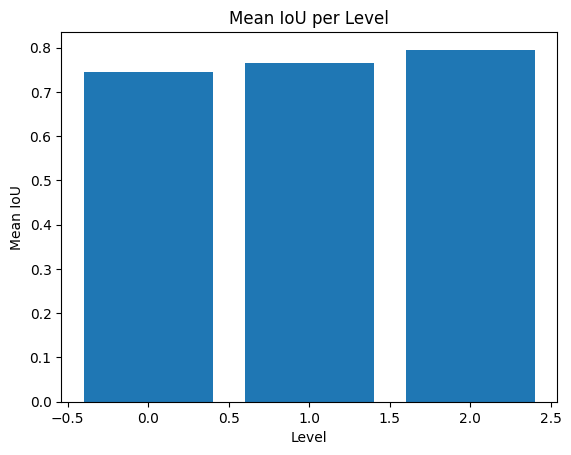

In [11]:
mean_ious = np.load(f"{output_dir}/mean_iou_levels_etci.npy")
plot_mean_iou_per_level(mean_ious)

In [12]:
mean_ious

array([0.74537349, 0.76559002, 0.79549003])

In [7]:
def plot_efficiency(mean_iou_levels, timings_levels):
    efficiency = np.array(mean_iou_levels) / np.array(timings_levels)
    plt.bar(range(len(efficiency)), efficiency)
    plt.xlabel('Level')
    plt.ylabel('Mean IoU per Second')
    plt.title('Efficiency per Level')
    plt.show()

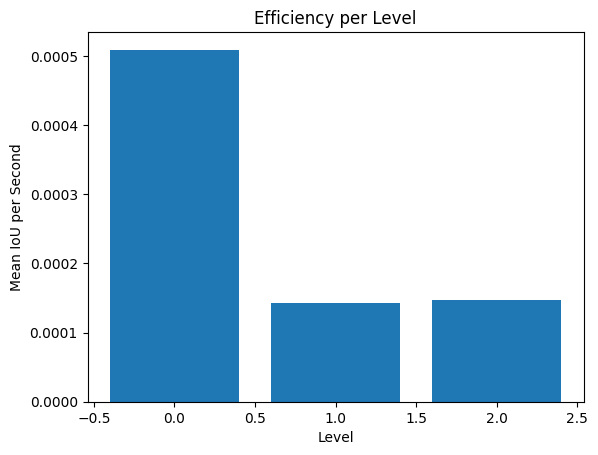

In [13]:
timings = np.load(f"{output_dir}/timings_levels_etci.npy")
plot_efficiency(mean_ious, timings)

In [27]:
from src.analyze import get_top_n_predictions, visualize_best_worst_predictions

best_idx, worst_idx = get_top_n_predictions(df=test_df, n=10, level=0)

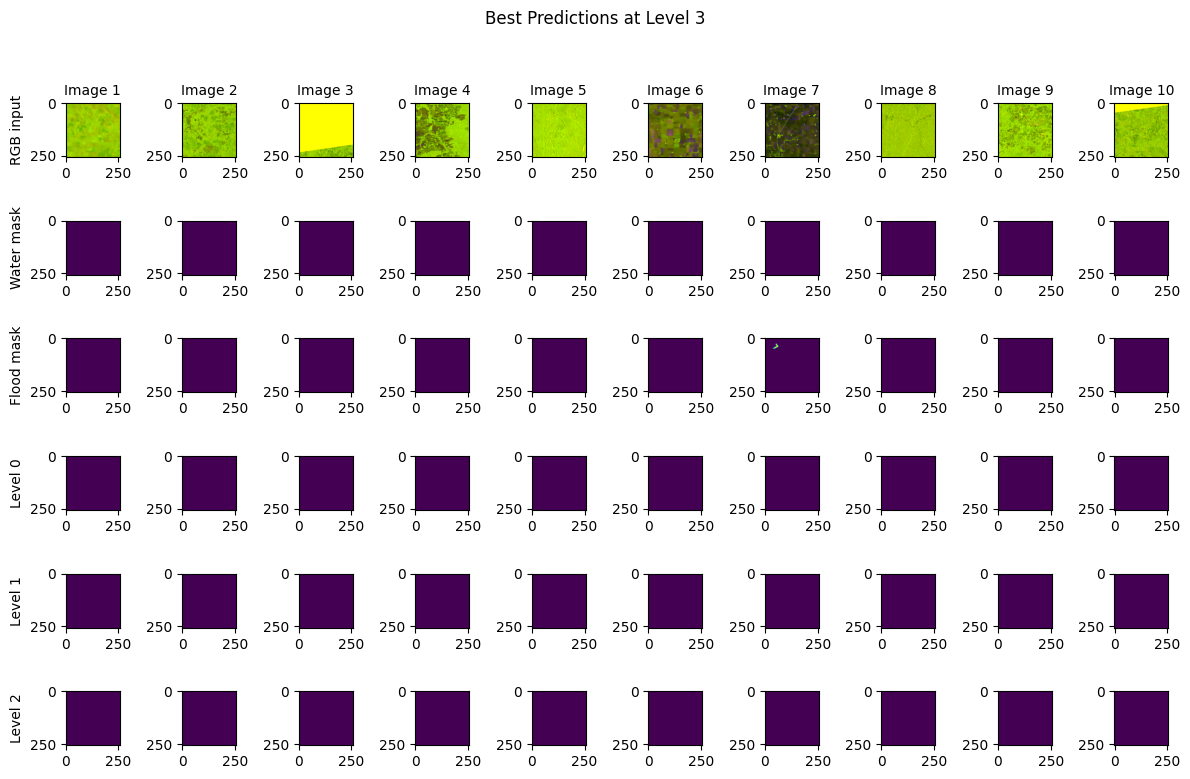

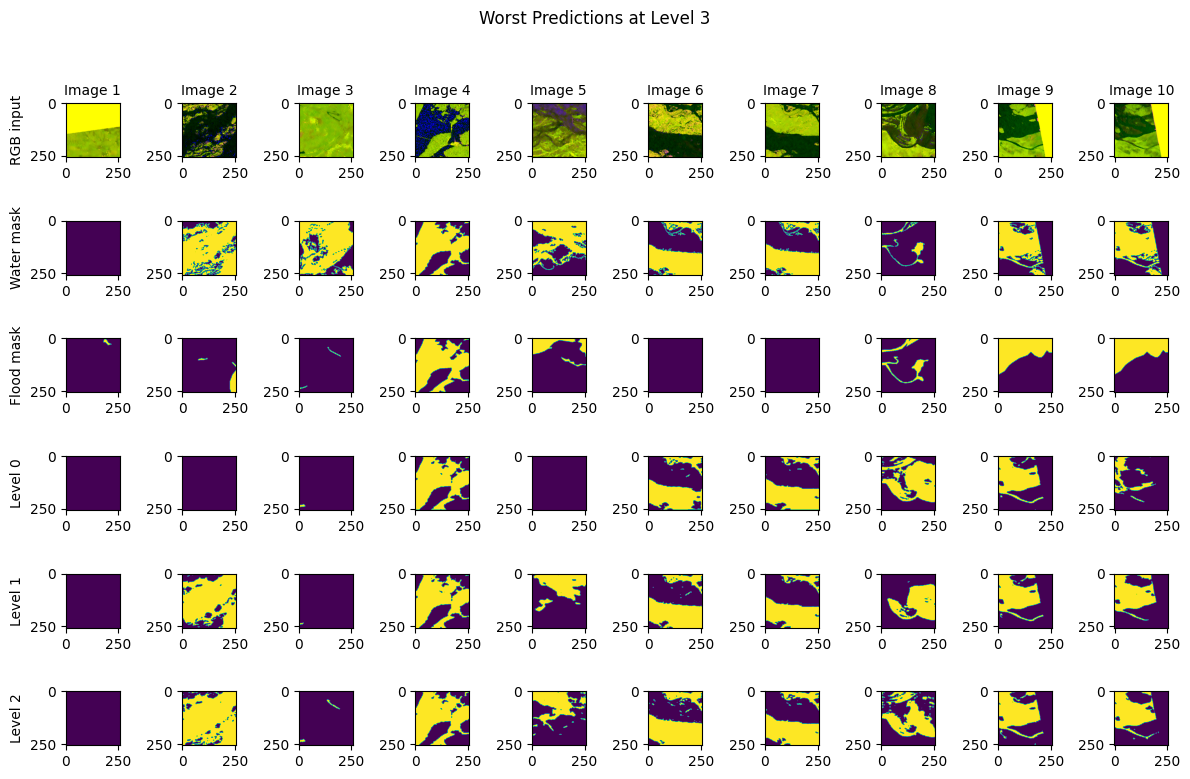

In [29]:
visualize_best_worst_predictions(test_df, best_idx, worst_idx, n_levels=3)

In [21]:
from src.analyze import compare_iou_scores

results = compare_iou_scores(df=test_df, list_of_levels=[0,1,2])

In [38]:
def plot_comparison(results):
    for transition, counts in results.items():
        labels = ['Improved', 'Worsened', 'Constant']
        values = [len(counts['improved']), len(counts['worsened']), len(counts['constant'])]
        plt.bar(labels, values)
        plt.title(f'IoU Changes from {transition}')
        plt.xlabel('Change Type')
        plt.ylabel('Count')
        plt.show()

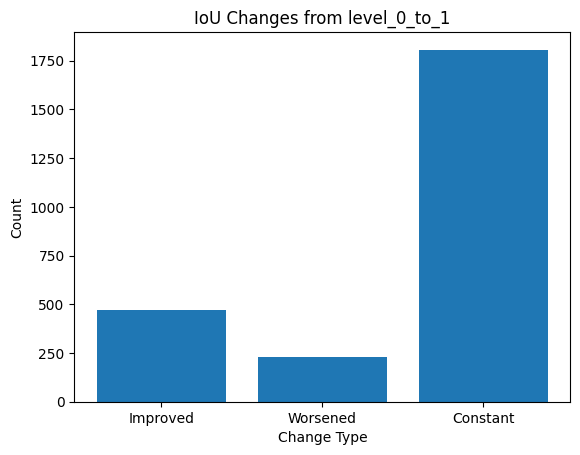

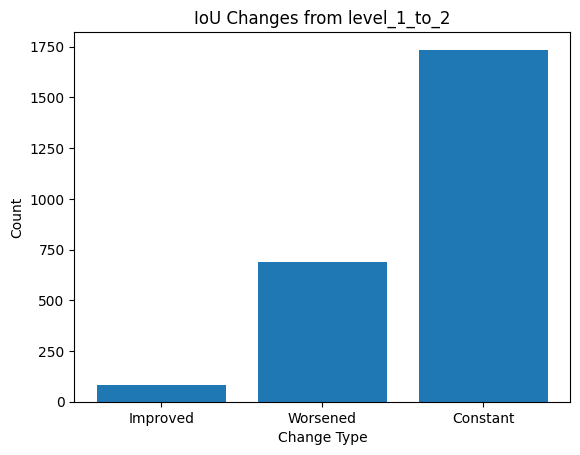

In [39]:
plot_comparison(results)

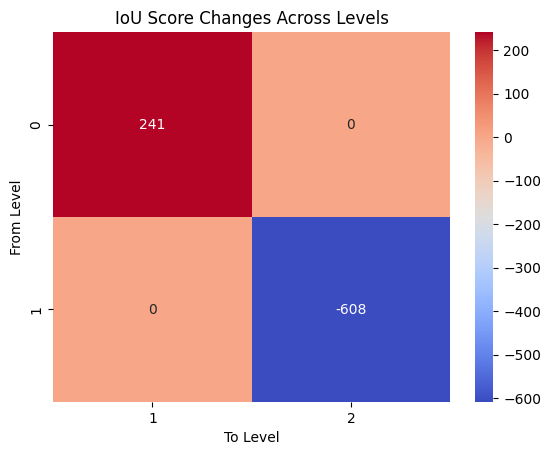

In [22]:
from src.analyze import plot_heatmap

plot_heatmap(results, list_of_levels=[0, 1, 2])

In [32]:
def update_metrics_dict(metrics_dict, new_metric):
    for key, value in new_metric.items():
        if key not in metrics_dict:
            metrics_dict[key] = value
        else:
            metrics_dict[key].update(value)



def collect_metrics_from_single_file(metric_base_name, levels, epochs_per_level, dataset="etci"):
    assert len(levels) == len(epochs_per_level), "Mismatch in number of levels and epochs_per_level"
    
    metrics_dict = {}
    file_name = f"{metric_base_name}_{dataset}.npy"
    file_path = os.path.join(output_dir, file_name)
    
    if os.path.exists(file_path):
        metrics_array = np.load(file_path)
        last_elements = metrics_array[-sum(epochs_per_level):]  # Get last elements based on sum of epochs per level

        start_idx = 0
        for level, num_epochs in zip(levels, epochs_per_level):
            end_idx = start_idx + num_epochs
            metrics_dict[str(level)] = last_elements[start_idx:end_idx].tolist()
            start_idx = end_idx
    else:
        print(f"File {file_name} does not exist.")
        
    return {metric_base_name: metrics_dict}

In [33]:
levels = [0, 1, 2]
epochs_per_level = [5, 20, 20]
metric_base_name = "train_losses"
dataset = "etci"

new_metric = collect_metrics_from_single_file("train_losses", levels, epochs_per_level, dataset)
update_metrics_dict(metrics_dict, new_metric)
new_metric = collect_metrics_from_single_file("val_losses", levels, epochs_per_level, dataset)
update_metrics_dict(metrics_dict, new_metric)

new_metric = collect_metrics_from_single_file("train_iou", levels, epochs_per_level, dataset)
update_metrics_dict(metrics_dict, new_metric)

new_metric = collect_metrics_from_single_file("val_iou", levels, epochs_per_level, dataset)
update_metrics_dict(metrics_dict, new_metric)

In [35]:
from src.analyze import plot_metrics
metrics_base_names = ["train_losses", "val_losses", "train_iou", "val_iou"]

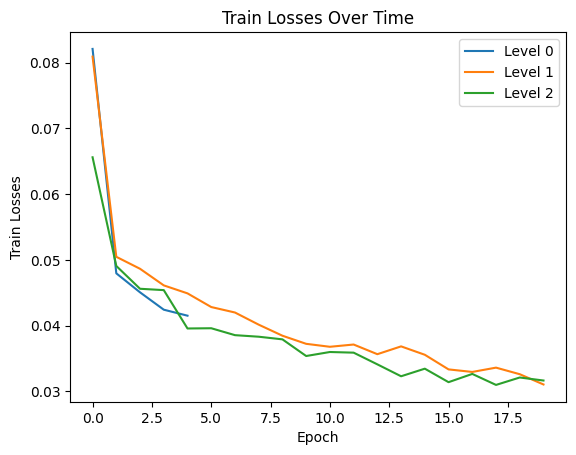

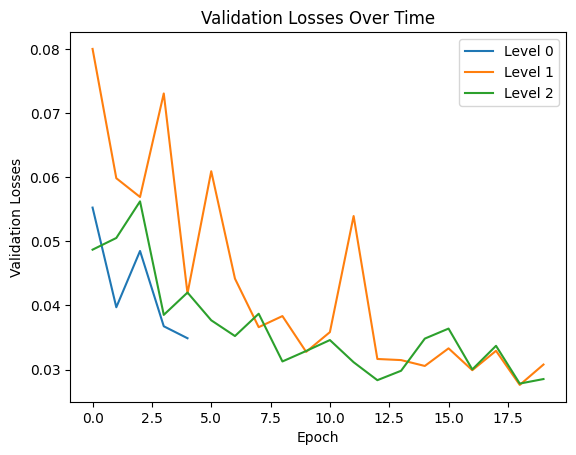

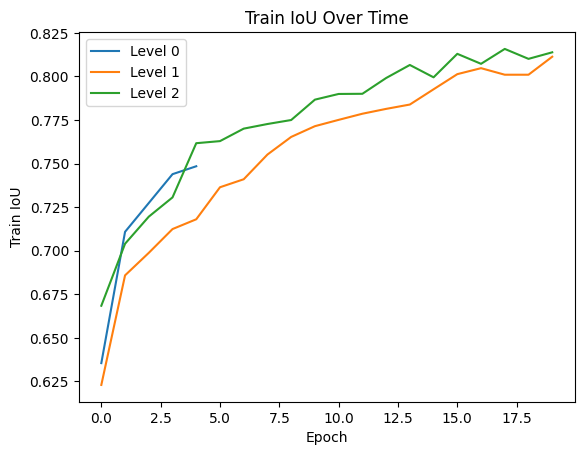

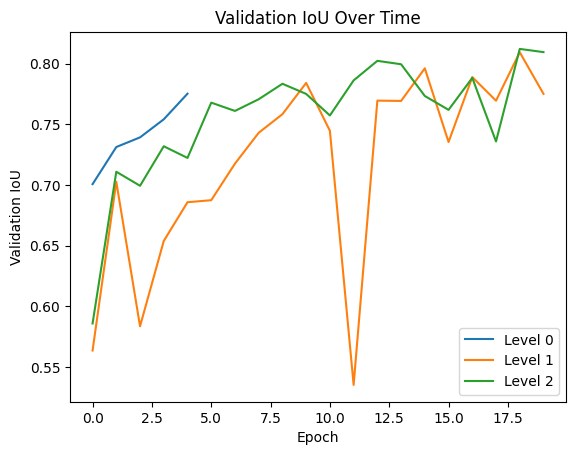

In [36]:
plot_metrics(metrics_dict['train_losses'], metric_name='Train Losses')
plot_metrics(metrics_dict['val_losses'], metric_name='Validation Losses')
plot_metrics(metrics_dict['train_iou'], metric_name='Train IoU')
plot_metrics(metrics_dict['val_iou'], metric_name='Validation IoU')